req         WARNING 	DEFAULT CACHE ENABLED! (578.98 MB) C:\Users\nitan\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Abu Dhabi Grand Prix - Practice 1 [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '5'

Model Performance:
RMSE: 0.4583 seconds
MAE: 0.3330 seconds
R² Score: -0.0946

Feature Importance:
           feature  importance
2         StartPos    0.623905
0     LapTimeQuali    0.243825
3  Avg_LapTime (s)    0.102982
4  Improvement (s)    0.029288
1     AvgPosChange    0.000000


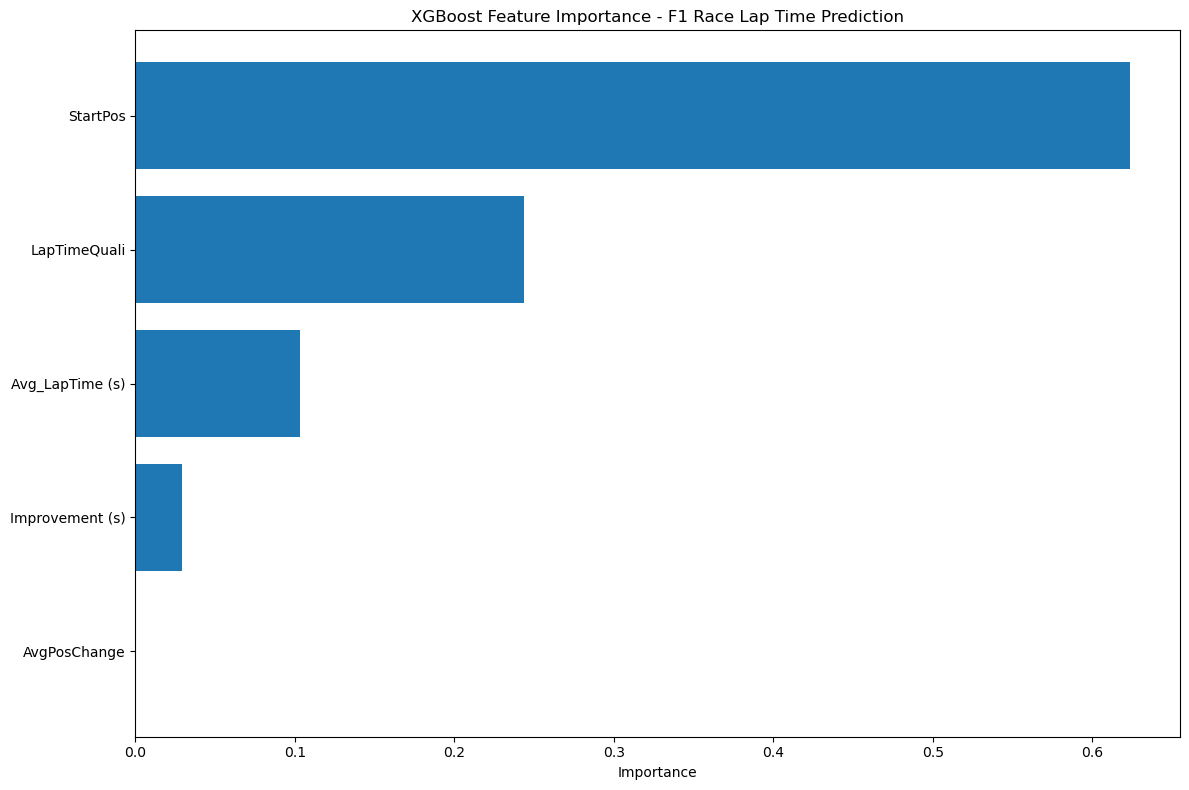

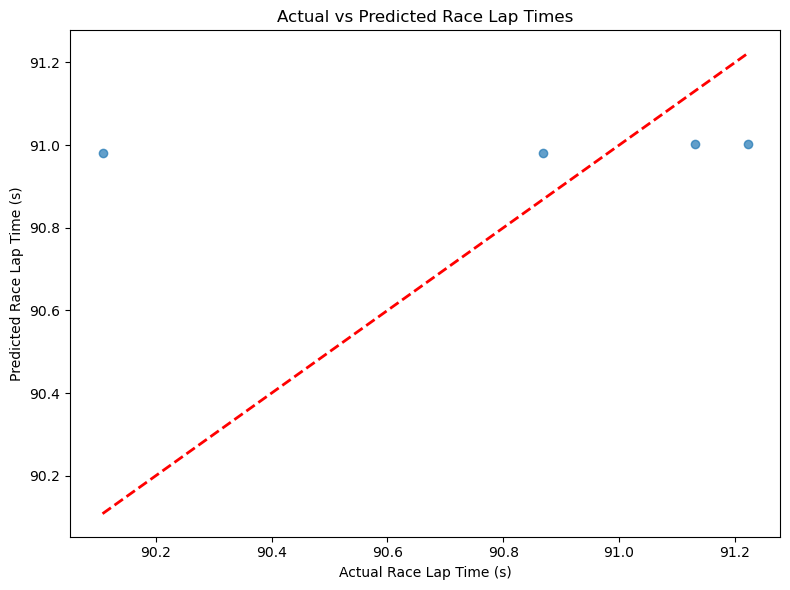


                    🏁 ABU DHABI GRAND PRIX PODIUM PREDICTION 🏁

🥇 WINNER
----------------------------------------
Driver: VER
Predicted Lap Time: 1:30.98 (90.9808s)
Leader

🥈 2ND PLACE
----------------------------------------
Driver: ALO
Predicted Lap Time: 1:30.98 (90.9809s)
Gap to leader: +0.0001s

🥉 3RD PLACE
----------------------------------------
Driver: PIA
Predicted Lap Time: 1:30.98 (90.9809s)
Gap to leader: +0.0001s


Predictions for all drivers:
   Driver  Actual_RaceLapTime  Predicted_RaceLapTime  Difference
19    VER           90.239088              90.980820   -0.741732
1     ALO           90.868386              90.980911   -0.112525
14    PIA           90.760614              90.980911   -0.220297
13    OCO           91.195643              90.980911    0.214732
15    RUS           90.107895              90.981705   -0.873810
12    NOR           89.511386              90.981705   -1.470319
7     HAD           91.195643              90.981918    0.213725
4     BOR         

In [1]:
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# load the 2025 Abu Dhabi free practice & 2024 race session data
FP1_2025 = fastf1.get_session(2025, 'Abu Dhabi Grand Prix', 'FP1')
FP2_2025 = fastf1.get_session(2025, 'Abu Dhabi Grand Prix', 'FP2')
FP3_2025 = fastf1.get_session(2025, 'Abu Dhabi Grand Prix', 'FP3')
Quali_2025 = fastf1.get_session(2025, 'Abu Dhabi Grand Prix', 'Q')
Race_2024 = fastf1.get_session(2024, 'Abu Dhabi Grand Prix', 'R')
FP1_2025.load()
FP2_2025.load()
FP3_2025.load()
Quali_2025.load()
Race_2024.load()

# extracting the required data
FP1_laps = FP1_2025.laps[["Driver", "LapTime", "SpeedST", "Compound"]].copy()
FP2_laps = FP2_2025.laps[["Driver", "LapTime", "SpeedST", "Compound"]].copy()
FP3_laps = FP3_2025.laps[["Driver", "LapTime", "SpeedST", "Compound"]].copy()
Quali_laps = Quali_2025.laps[["Driver", "LapTime", "SpeedST", "Compound"]].copy()
Race_laps = Race_2024.laps[["Driver", "LapTime", "Sector1Time", "Sector2Time", "Sector3Time"]].copy()

# dropping the nan values
FP1_laps.dropna(inplace=True)
FP2_laps.dropna(inplace=True)
FP3_laps.dropna(inplace=True)
Quali_laps.dropna(inplace=True)
Race_laps.dropna(inplace=True)

# converting all laptimes to seconds
FP1_laps['LapTimeFP1'] = FP1_laps['LapTime'].dt.total_seconds()
FP2_laps['LapTimeFP2'] = FP2_laps['LapTime'].dt.total_seconds()
FP3_laps['LapTimeFP3'] = FP3_laps['LapTime'].dt.total_seconds()
Quali_laps['LapTimeQuali'] = Quali_laps['LapTime'].dt.total_seconds()
Race_laps['LapTimeRace'] = Race_laps['LapTime'].dt.total_seconds()

FP1_laps.drop(['LapTime'],axis=1,inplace=True)
FP2_laps.drop(['LapTime'],axis=1,inplace=True)
FP3_laps.drop(['LapTime'],axis=1,inplace=True)
#Quali_laps.drop(['LapTime'],axis=1,inplace=True)
Race_laps.drop(['LapTime'],axis=1,inplace=True)

def process_session_data(laps_df, session_suffix, laptime_column):
    # copy to avoid modifying original
    data = laps_df.copy()
    
    # find most used tire compound per driver
    data['TireCount'] = data.groupby(['Driver', 'Compound'])['Compound'].transform('count')
    max_count = data.groupby('Driver')['TireCount'].transform('max')
    data = data[data['TireCount'] == max_count]
    
    # aggregate by driver and compound
    result = data.groupby(['Driver', 'Compound']).agg({
        'SpeedST': 'mean',
        laptime_column: 'mean'
    }).reset_index()
    
    # rename columns
    result.rename(columns={
        'Compound': f'Compound{session_suffix}',
        'SpeedST': f'SpeedST{session_suffix}',
        laptime_column: f'LapTime{session_suffix}'
    }, inplace=True)
    
    # keep one record per driver and clean up
    return result.drop_duplicates(subset=['Driver'], keep='first').reset_index(drop=True)

# apply to all sessions with correct column naming
FP1_result = process_session_data(FP1_laps, 'FP1', 'LapTimeFP1')  
FP2_result = process_session_data(FP2_laps, 'FP2', 'LapTimeFP2')    
FP3_result = process_session_data(FP3_laps, 'FP3', 'LapTimeFP3')

Quali_result = Quali_laps.groupby(['Driver', 'Compound']).agg({
'SpeedST': 'mean',
'LapTimeQuali': 'min'
})
Quali_result = Quali_result.reset_index()
Quali_result.rename(columns={'Compound': 'CompoundQuali', 'SpeedST': 'SpeedSTQuali'}, inplace=True)
Quali_result.drop_duplicates(subset=['Driver'],keep='first', inplace=True)
Quali_result = Quali_result.reset_index(drop=True)

# processing the race session to get the average lap time for the entire race
Race_result = Race_laps.groupby(['Driver']).agg({'LapTimeRace': 'mean'})
Race_result = Race_result.reset_index()

# creating a feature dataframe to hold the feature columns
feature = FP3_result.copy()
feature = feature.merge(FP2_result, on="Driver", how="left")
feature = feature.merge(FP1_result, on="Driver", how="left")
feature = feature.merge(Quali_result, on="Driver", how="left")
feature = feature.reset_index()
feature.drop(['index'],axis=1,inplace=True)

# After keeping the tires in the initial models, it seems that the tyres are not affecting the results, hence dropping the tyre features
#feature.dropna(inplace=True)
feature = feature.reset_index(drop=True)
feature.drop(['CompoundFP1', 'CompoundFP2', 'CompoundFP3', 'CompoundQuali'],axis=1,inplace=True)

# average change of position for the last Two years in Abu Dhabi
# '+' means positions gained & '-' means position lost
avg_pos_chng_Abu_Dhabi = {
    'PIA' : -5.50,
    'NOR': 0.00,
    'HAM': 5.33,
    'LEC': 5.00,
    'VER': -2.33,
    'SAI': -0.33,
    'PER': -1.00,
    'RUS': -2.67,
    'TSU': -1.33,
    'STR': 3.67,
    'ALO': 0.33,
    'HUL': -4.00,
    'ALB': 1.00,
    'BOT': -5.00,
    'OCO': 0.00,
    'ZHO': -2.00,
    'GAS': -3.33
}
# starting position of the driver on the race day
start_pos = {
    'PIA' : 3.00,
    'NOR': 2.00,
    'HAM': 16.00,
    'LEC': 5.00,
    'VER': 1.00,
    'SAI': 12.00,
    'RUS': 4.00,
    'TSU': 10.00,
    'STR': 15.00,
    'ALO': 6.00,
    'HUL': 18.00,
    'ALB': 17.00,
    'OCO': 8.00,
    'GAS': 19.00,
    'HAD': 9.00,
    'LAW': 13.00,
    'ANT': 14.00,
    'BOR': 7.00,
    'COL': 20.00,
    'BEA': 11.00
}
# adding the position change data & starting position to features
feature['AvgPosChange'] = feature['Driver'].map(avg_pos_chng_Abu_Dhabi)
feature['StartPos'] = feature['Driver'].map(start_pos)
feature.fillna(0, inplace=True)

# calculating average laptimes during all practice sessions
feature["Avg_LapTime (s)"] = (
   ( feature["LapTimeFP1"] +
    feature["LapTimeFP2"] +
    feature["LapTimeFP3"])/3
)
# calculates the improvement in average speed time between practice 3 and practice 1
feature["Improvement (s)"] = (
    feature["LapTimeFP3"] -
    feature["LapTimeFP1"])
feature.drop(['SpeedSTFP1', 'SpeedSTFP2', 'SpeedSTFP3', 'LapTimeFP1', 'LapTimeFP2', 'LapTimeFP3', 'SpeedSTQuali'],axis=1,inplace=True)


feature = feature.merge(Race_result, on="Driver", how="left")
feature['LapTimeRace'] = feature['LapTimeRace'].fillna(Race_result['LapTimeRace'].mean())

from sklearn.model_selection import train_test_split
X = feature.iloc[:,1:6]
y = feature.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Apply normalization (scales features to range [0, 1])
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)  # Normalize all data for final predictions

constraints = '(1, -1, 1, 1, 0)'

# Initialize and configure XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=3000,
    max_depth=6,
    learning_rate=0.0001,
    objective='reg:squarederror',
    random_state=42,
    min_child_weight= 7,
    colsample_bytree=0.7,
    subsample= 0.7,
    monotone_constraints=constraints
)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions on normalized test data
y_pred = xgb_model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"RMSE: {rmse:.4f} seconds")
print(f"MAE: {mae:.4f} seconds")
print(f"R² Score: {r2:.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance - F1 Race Lap Time Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Race Lap Time (s)')
plt.ylabel('Predicted Race Lap Time (s)')
plt.title('Actual vs Predicted Race Lap Times')
plt.tight_layout()
plt.show()

# Predictions for all drivers using normalized data
all_predictions = xgb_model.predict(X_scaled)
results = pd.DataFrame({
    'Driver': feature['Driver'],
    'Actual_RaceLapTime': feature['LapTimeRace'],
    'Predicted_RaceLapTime': all_predictions,
    'Difference': feature['LapTimeRace'] - all_predictions
})
results = results.sort_values('Predicted_RaceLapTime')

# ABU DHABI GP PODIUM PREDICTION SECTION
print("\n" + "="*80)
print(" "*20 + "🏁 ABU DHABI GRAND PRIX PODIUM PREDICTION 🏁")
print("="*80)

# Get top 3 drivers based on predicted lap times
podium = results.head(3).copy()
positions = ['🥇 WINNER', '🥈 2ND PLACE', '🥉 3RD PLACE']

# Display podium predictions
for idx in range(3):
    driver_data = podium.iloc[idx]
    print(f"\n{positions[idx]}")
    print("-" * 40)
    print(f"Driver: {driver_data['Driver']}")
    
    # Format time as MM:SS.ss
    lap_time = driver_data['Predicted_RaceLapTime']
    minutes = int(lap_time // 60)
    seconds = lap_time % 60
    print(f"Predicted Lap Time: {minutes}:{seconds:05.2f} ({lap_time:.4f}s)")
    
    # Calculate gap to leader (not for winner)
    if idx == 0:
        print("Leader")
    else:
        gap_to_leader = lap_time - podium.iloc[0]['Predicted_RaceLapTime']
        print(f"Gap to leader: +{gap_to_leader:.4f}s")

print("\n" + "="*80)

print("\nPredictions for all drivers:")
print(results)